In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

### prepare data

In [2]:
X = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    # Asking about age
    "How old are you?",
    "what is your age?",
]

y = [0,0,0,1,1,1,2,2,2,3,3]

### load model and plot initial similarity martix

In [3]:
def plot_similarity(labels, features, rotation):
    corr = np.inner(features, features)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")


def run_and_plot(session_, input_tensor_, messages_, encoding_tensor):
    message_embeddings_ = session_.run(
      encoding_tensor, feed_dict={input_tensor_: messages_})
    plot_similarity(messages_, message_embeddings_, 90)

INFO:tensorflow:Restoring parameters from b'model/variables/variables'


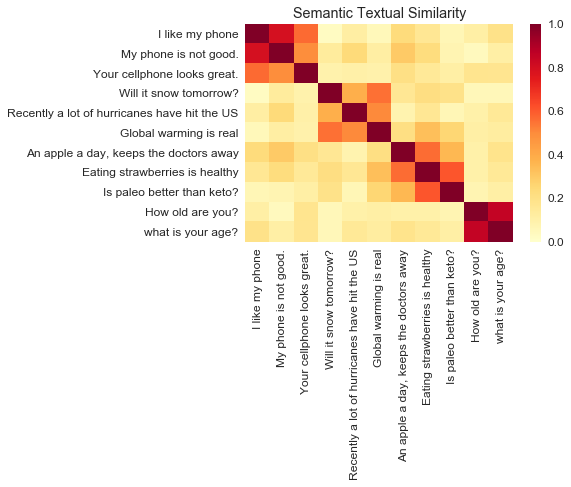

In [4]:
from tensorflow.python.saved_model import tag_constants

scope = 'finetune'

graph=tf.Graph()

with tf.Session(graph=graph) as sess:
    model_path = 'model/'
    tf.saved_model.loader.load(sess, [tag_constants.SERVING], model_path)
    
    sess.run(tf.global_variables_initializer())
    sess.run(tf.get_default_graph().get_operation_by_name('finetune/init_all_tables'))

    in_tensor = tf.get_default_graph().get_tensor_by_name(scope + '/module/fed_input_values:0')
    ou_tensor = tf.get_default_graph().get_tensor_by_name(scope + '/module/Encoder_en/hidden_layers/l2_normalize:0')

    run_and_plot(sess, in_tensor, X, ou_tensor)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



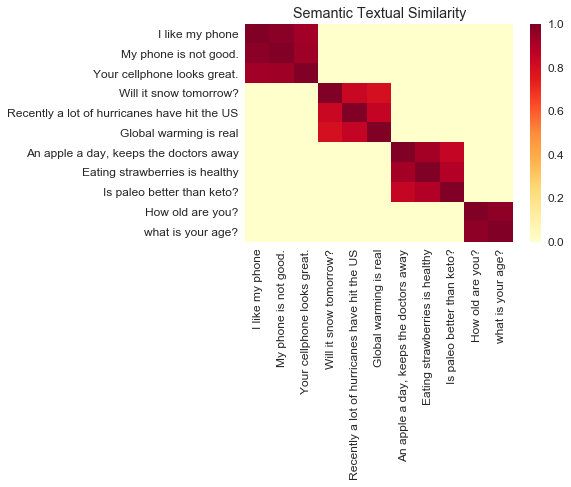

In [5]:
from tensorflow.python.saved_model import tag_constants

scope = 'finetune'

with tf.Session(graph=graph) as sess:
    
    # universal sentence encoder input/output
    in_tensor = tf.get_default_graph().get_tensor_by_name(scope + '/module/fed_input_values:0')
    ou_tensor = tf.get_default_graph().get_tensor_by_name(scope + '/module/Encoder_en/hidden_layers/l2_normalize:0')

    # a simple softmax classification on top of universal sentence encoder
    input_y = tf.placeholder(tf.int32, shape=(None))
    labels = tf.one_hot(input_y, 4)
    logits = tf.layers.dense(ou_tensor, 4)
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels)
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

    sess.run(tf.global_variables_initializer())
    sess.run(tf.get_default_graph().get_operation_by_name('finetune/init_all_tables'))

    for epoch in range(10):
        feed_dict = {
            in_tensor: X,
            input_y: y
        }
        sess.run(optimizer, feed_dict)

    run_and_plot(sess, in_tensor, X, ou_tensor)